In [1]:
%load_ext autoreload
%autoreload 2

import torch

from torch.utils.data import DataLoader

from src.deep_ad.config import Config
from src.deep_ad.data.dagm_split import dagm_patch_get_splits
from src.deep_ad.measurements import GPUWatch
from src.deep_ad.model import DeepCNN
from src.deep_ad.trainer import TrainerWatch
from src.deep_ad.transforms import create_training_transform, create_validation_transform

In [2]:
# Load the configuration
config = Config(root_dir='..')

### Measure GPU memory during training

Run the model only one epoch on only one batch and measure the memory and time usage on each instruction.

In [3]:
# Start measuring GPU memory
gpuwatch = GPUWatch()

In [4]:
# Load the model
print(f"Free GPU memory: {gpuwatch.start()} MiB")
model = DeepCNN().to(config.device)
print(f"{gpuwatch.checkpoint():+5d} MiB | DeepCNN()")
model_num_params = sum(p.numel() for p in model.parameters())
print(f"Model has {model_num_params:,} parameters")

Free GPU memory: 5327 MiB
  -75 MiB | DeepCNN()
Model has 1,444,737 parameters


In [5]:
# Load the datasets
gpuwatch.checkpoint()
train_transform = create_training_transform(config)
print(f"{gpuwatch.checkpoint():+5d} MiB | train_transform")
val_transform = create_validation_transform(config)
print(f"{gpuwatch.checkpoint():+5d} MiB | val_transform")
train_dataset, val_dataset, test_dataset = dagm_patch_get_splits(config, train_transform, val_transform)
print(f"{gpuwatch.checkpoint():+5d} MiB | dagm_patch_get_splits()")

   +0 MiB | train_transform
   +0 MiB | val_transform
   +0 MiB | dagm_patch_get_splits()


In [6]:
# Create the dataloaders
gpuwatch.checkpoint()
train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
print(f"{-gpuwatch.checkpoint():+5d} MiB | train_dataloader")
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
print(f"{-gpuwatch.checkpoint():+5d} MiB | validation_dataloader")
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
print(f"{-gpuwatch.checkpoint():+5d} MiB | test_dataloader")

   +0 MiB | train_dataloader
   +2 MiB | validation_dataloader
   +0 MiB | test_dataloader


In [7]:
# Create the trainer
gpuwatch.checkpoint()
trainer = TrainerWatch(config, model, train_dataloader, val_dataloader, train_epochs=1000, limit_batches=1)
print(f"{-gpuwatch.checkpoint():+5d} MiB | TrainerWatch()")

   +0 MiB | TrainerWatch()


In [8]:
train_losses, val_losses = trainer.train()

0.109 s,    +0 MiB | enumerate(self.train_dataloader)
0.045 s,    +0 MiB | optimizer.zero_grad()
0.034 s,   -20 MiB | images.to(device)
0.077 s,   -10 MiB | inputs = images * (1 - self.mask)
0.467 s, -5056 MiB | output = self.model(inputs)
0.070 s,    +0 MiB | loss = self.loss_function(output, images)
1.448 s,   -50 MiB | loss.backward()
0.079 s,   -16 MiB | optimizer.step()
0.052 s,    +0 MiB | epoch_loss += loss.item()
2.461 s, -5152 MiB | train_epoch()
0.253 s,    +0 MiB | eval_epoch()
Epoch   1/1000: Train Loss 0.001565, Val Loss 0.001511, 3.005 s, -5150 MiB
Epoch   2/1000: Train Loss 0.001493, Val Loss 0.001441, 3.029 s,   +20 MiB
Epoch   3/1000: Train Loss 0.001413, Val Loss 0.001330, 3.036 s,    +6 MiB
Epoch   4/1000: Train Loss 0.001307, Val Loss 0.001108, 3.160 s,   +20 MiB
Epoch   5/1000: Train Loss 0.001070, Val Loss 0.000675, 2.894 s,    -2 MiB
Epoch   6/1000: Train Loss 0.000663, Val Loss 0.000971, 2.884 s,    +6 MiB
Epoch   7/1000: Train Loss 0.000998, Val Loss 0.000657, 

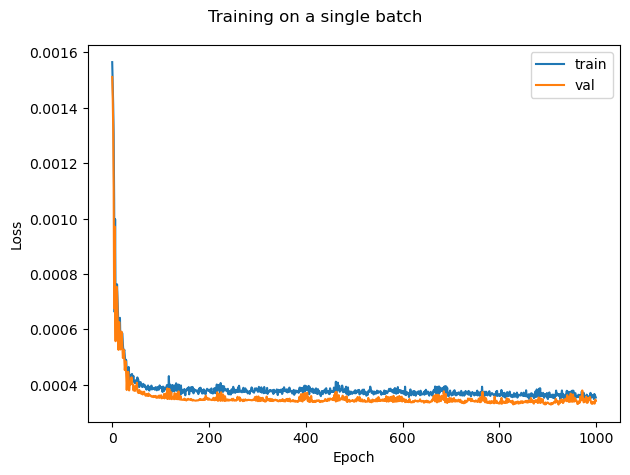

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.suptitle('Training on a single batch')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
images, keys = next(iter(trainer.val_dataloader))
input_images = []
outputs = []
for i in range(4):
    image = images[i]
    input_images.append(image.squeeze().detach().cpu().numpy())
    input = image.unsqueeze(0).to(config.device)
    input[48:80, 48:80] = 0
    output = model(input)
    outputs.append(output.squeeze().detach().cpu().numpy())

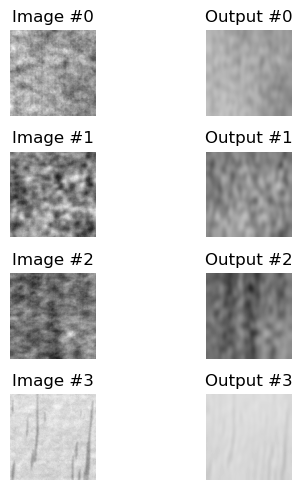

In [11]:
%matplotlib inline
from src.deep_ad.image import plot_images

def flatten(xs):
    return [x for ys in xs for x in ys]

titles = flatten([[f"Image #{i}", f"Output #{i}"] for i in range(4)])
plot_images(flatten(list(zip(input_images, outputs))), titles, rows=4, cols=2)

In [12]:
overview_df = trainer.get_overview_df()
display(overview_df.style.hide())

Instruction,Total T,Avg T,Total GPU,Avg GPU
enumerate(self.train_dataloader),1m 26s,0.087s,-25 MiB,-0 MiB
optimizer.zero_grad(),39.337s,0.039s,-40 MiB,-0 MiB
images.to(device),44.420s,0.044s,-25 MiB,-0 MiB
inputs = images * (1 - self.mask),44.017s,0.044s,-3 MiB,-0 MiB
output = self.model(inputs),1m 24s,0.084s,-5015 MiB,-5 MiB
"loss = self.loss_function(output, images)",6m 39s,0.400s,-12 MiB,-0 MiB
loss.backward(),6m 59s,0.420s,-67 MiB,-0 MiB
optimizer.step(),17m 24s,1.044s,+19 MiB,+0 MiB
epoch_loss += loss.item(),41.022s,0.041s,+15 MiB,+0 MiB
train_epoch(),38m 10s,2.291s,-5153 MiB,-5 MiB


In [13]:
# Free cache
torch.cuda.empty_cache()

In [14]:
# Print CUDA memory summary
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 161098 KiB |   4704 MiB |  28196 GiB |  28196 GiB |
|       from large pool | 136202 KiB |   4687 MiB |  28178 GiB |  28178 GiB |
|       from small pool |  24896 KiB |     27 MiB |     17 GiB |     17 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 161098 KiB |   4704 MiB |  28196 GiB |  28196 GiB |
|       from large pool | 136202 KiB |   4687 MiB |  28178 GiB |